In [1]:
data_dir= '/n/holylfs/LABS/wadduwage_lab/Lab/navodini/dCNN_Datasets/Blood_Vessels/6SLS'

In [2]:
import h5py
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import mat73
from skimage.transform import rescale
import torch
import torch.nn.functional as F
# !pip install apeer-ometiff-library
# from apeer_ometiff_library import io

In [3]:
def read_data(forward_data):
    data_dict = mat73.loadmat(forward_data)
    Ex = data_dict['E']
    PSFs_dict = data_dict['PSFs']
    
    emPSF = data_dict['PSFs']['emPSF']
    sPSF = data_dict['PSFs']['sPSF']
    exPSF = data_dict['PSFs']['exPSF']
    
    pram_PSF = data_dict['PSFs']['pram']
    pram_dict = data_dict['pram']
    
    return Ex, sPSF, emPSF, exPSF, pram_PSF, pram_dict

In [4]:
forward_data = f'{data_dir}/mouse_bv_300um_data_6sls_2.295395e+01mc21-Oct-2021 21:39:52_pram_plusplus.mat'

Ex, sPSF, emPSF, exPSF, pram_PSF, pram_dict = read_data(forward_data)

print(f"Shape of Exication pattern data {Ex.shape}")
print(f"Shape of emPSF data {emPSF.shape}")
print(f"Shape of sPSF data {sPSF.shape}")

Shape of Exication pattern data (326, 326, 32)
Shape of emPSF data (1305, 1305, 67)
Shape of sPSF data (1305, 1305, 67)


In [5]:
sliced = sPSF.shape[-1]//2  # Get the slice in center from 3D stack

sPSF_2d = sPSF[:,:,sliced]
emPSF_2d = emPSF[:,:,sliced]
exPSF_2d = exPSF[:,:,sliced]

In [13]:
np.save("../psfs/psfs_bloodvesselsDeepTFM6sls_spsf.npy", sPSF_2d)
np.save("../psfs/psfs_bloodvesselsDeepTFM6sls_expsf.npy", exPSF_2d)
np.save("../psfs/psfs_bloodvesselsDeepTFM6sls_empsf.npy", emPSF_2d)

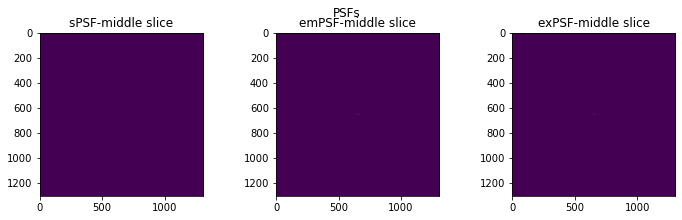

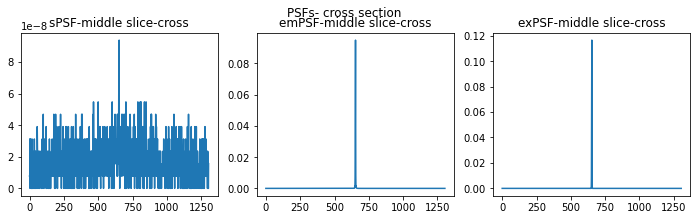

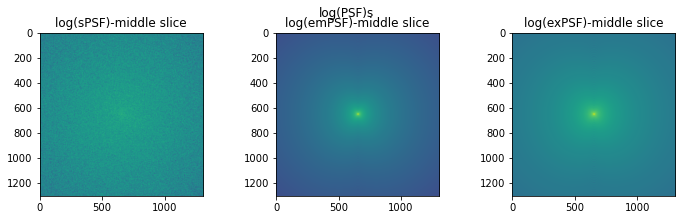

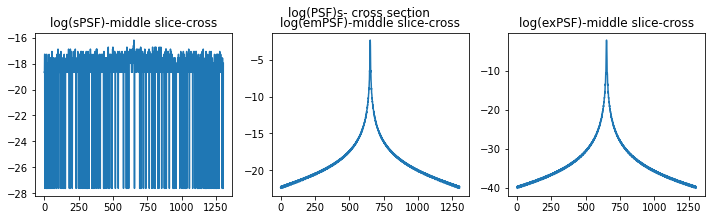

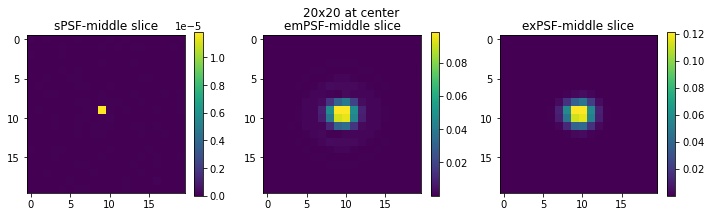

In [8]:
plt.figure(figsize= (12, 3))
plt.subplot(1,3,1)
plt.imshow(sPSF_2d)
plt.title('sPSF-middle slice')
plt.subplot(1,3,2)
plt.imshow(emPSF_2d)
plt.title('emPSF-middle slice')
plt.subplot(1,3,3)
plt.imshow(exPSF_2d)
plt.title('exPSF-middle slice')
plt.suptitle('PSFs', y=1)
plt.show()

plt.figure(figsize= (12, 3))
plt.subplot(1,3,1)
plt.plot(sPSF_2d[653])  #min: 0, 9.375e-08, ...
plt.title('sPSF-middle slice-cross')
plt.subplot(1,3,2)
plt.plot(emPSF_2d[653])
plt.title('emPSF-middle slice-cross')
plt.subplot(1,3,3)
plt.plot(exPSF_2d[653])
plt.title('exPSF-middle slice-cross')
plt.suptitle('PSFs- cross section', y=1)
plt.show()

plt.figure(figsize= (12, 3))
plt.subplot(1,3,1)
plt.imshow(np.log(sPSF_2d + 1e-12))  #min: 0, 9.375e-08, ...
plt.title('log(sPSF)-middle slice')
plt.subplot(1,3,2)
plt.imshow(np.log(emPSF_2d))
plt.title('log(emPSF)-middle slice')
plt.subplot(1,3,3)
plt.imshow(np.log(exPSF_2d))
plt.title('log(exPSF)-middle slice')
plt.suptitle('log(PSF)s', y=1)
plt.show()


plt.figure(figsize= (12, 3))
plt.subplot(1,3,1)
plt.plot(np.log(sPSF_2d + 1e-12)[653])  #min: 0, 9.375e-08, ...
plt.title('log(sPSF)-middle slice-cross')
plt.subplot(1,3,2)
plt.plot(np.log(emPSF_2d)[653])
plt.title('log(emPSF)-middle slice-cross')
plt.subplot(1,3,3)
plt.plot(np.log(exPSF_2d)[653])
plt.title('log(exPSF)-middle slice-cross')
plt.suptitle('log(PSF)s- cross section', y=1)
plt.show()


plt.figure(figsize= (12, 3))
plt.subplot(1,3,1)
plt.imshow(sPSF_2d[643:663, 643:663])
plt.colorbar()
plt.title('sPSF-middle slice')
plt.subplot(1,3,2)
plt.imshow(emPSF_2d[643:663, 643:663])
plt.colorbar()
plt.title('emPSF-middle slice')
plt.subplot(1,3,3)
plt.imshow(exPSF_2d[643:663, 643:663])
plt.colorbar()
plt.title('exPSF-middle slice')
plt.suptitle('20x20 at center', y=1)
plt.show()

In [9]:
filename_train = f'{data_dir}/mouse_bv_300um_data_6sls_2.295395e+01mc_tr.h5'
filename_test = f'{data_dir}/mouse_bv_300um_data_6sls_2.295395e+01mc_test.h5'

with h5py.File(filename_train, "r") as f:gt_train = np.array(f['gt'])
with h5py.File(filename_test, "r") as f:gt_test = np.array(f['gt'])

In [10]:
print(f"Number of data available (train) : {len(gt_train)}")
print(f"Shape of an image {gt_train[0].shape}")
print(f"Number of data available (test) : {len(gt_test)}")
print(f"Shape of an image {gt_test[0].shape}")

Number of data available (train) : 11345
Shape of an image (1, 326, 326)
Number of data available (test) : 128
Shape of an image (1, 326, 326)


In [39]:
assert gt_train.max() == gt_test.max(), 'train and test max are different -> Check how much they differ'
max_value= gt_train.max()
print(f'max value : {max_value}')

max value : 22.953956604003906


In [40]:
import os
import cv2
import shutil
def save_imgs(img_array, save_dir, type_= 'train'):
    save_dir = f'{save_dir}/{type_}'
    
    try:shutil.rmtree(save_dir)
    except:pass
    os.mkdir(save_dir)
    
    for i, img in enumerate(img_array):
        cv2.imwrite(f'{save_dir}/{i}.png', (img*255.0).astype('uint8'))
        if i%50==0:print(f'{i} savings completed: {save_dir}')

In [41]:
save_dir= '/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bloodvesselsDeepTFM6sls'
#os.mkdir(save_dir) # train, test= val

In [ ]:
save_imgs(gt_test[:,0]/max_value, save_dir, type_= 'test')
save_imgs(gt_test[:,0]/max_value, save_dir, type_= 'val')
save_imgs(gt_train[:,0]/max_value, save_dir, type_= 'train')

## DataLoaders

In [1]:
import sys

from modules.datasets import *
from modules.data_utils import *

total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bloodvesselsDeepTFM6sls/train -> 11345
total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bloodvesselsDeepTFM6sls/val -> 128
total images found in: /n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bloodvesselsDeepTFM6sls/test -> 128
dataset lenths : 2000 | 50 | 50


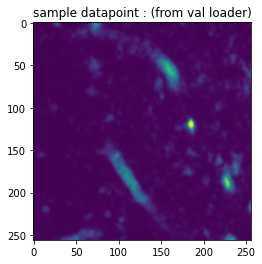

dataset value range :  0.004021176602691412 0.9960788488388062


In [2]:
img_size= 256
delta= 0.0001
num_samples_train= 2000
num_samples_valtest= 50
batch_size_train= 32

trainset, valset, testset = bloodvesselsDeepTFM6sls(img_size= img_size, delta= delta, num_samples_train= num_samples_train, num_samples_valtest= num_samples_valtest)

drop_last_val_test= True

train_loader, val_loader, test_loader = return_dataloaders(trainset, valset, testset, batch_size_train= batch_size_train, drop_last_val_test= drop_last_val_test)


## Freq-domain conv

In [19]:
#x_centered.shape (b, m, m)
def fft_conv2d(X, filter_): # X.shape: (b, 1, m, m), filter_.shape: (1, 1, f, f) -> similar to standard conv [note: f> m]
    X= X[:, 0]
    filter_= filter_[:, 0]
    
    _, m, _ = X.shape
    _, f, _ = filter_.shape
    a, b, c, d= (f-m)//2 + 1, (f-m)//2, (f-m)//2 + 1, (f-m)//2
    
    X= torch.nn.functional.pad(X, (a, b, c, d)) # make X.shape= filter_.shape [note: filter_ is larger than image]
    X_fft_centered = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(X)))
    filter_fft_centered = torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(filter_)))
    fft_centered_convolved = X_fft_centered * filter_fft_centered
    X_conved = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(fft_centered_convolved)))
    
    X_conved= X_conved[:, c:-d, a:-b] ## c+1: -d+1 instead c: -d -> because, freq-domain mult. shift the image (DO NOT KNOW WHY??)
    return X_conved.abs().unsqueeze(dim= 1) # shape: (b, 1, m, m)

In [2]:
import sys
sys.path.append('../')

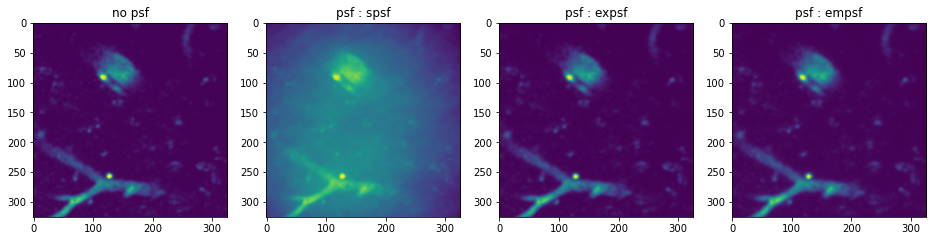

In [18]:
import cv2
import torch
import matplotlib.pyplot as plt
from modules.psfs import *
from torch.nn import functional as F

img =   plt.imread('/n/holylfs/LABS/wadduwage_lab/Lab/uom_Udith/datasets/bloodvesselsDeepTFM6sls/train/1.png')

X = torch.tensor(img).unsqueeze(dim= 0).unsqueeze(dim= 0)

plt.figure(figsize= (16, 6))
plt.subplot(1,4,1)
plt.imshow(X[0, 0])
plt.title('no psf')

outs= []
for i, psf in enumerate(['spsf', 'expsf', 'empsf']):
    filter_= load_psf_from_npy(f"../psfs/psfs_bloodvesselsDeepTFM6sls_{psf}.npy")
    filter_= filter_.unsqueeze(dim= 0).unsqueeze(dim= 0)

    out_fft = fft_conv2d(X, filter_)
    
    plt.subplot(1,4,i+2)
    plt.imshow(out_fft[0, 0])
    plt.title(f'psf : {psf}')
    
    outs.append(out_fft)
